# News Articles Categorization

## Overview

 According to Internet Live Stats, in every second, around 9,000 tweets are posted; 3 million emails are sent and more than 90,000 GB of Internet traffic. So, we have a big amount of data in the internet. With such data, it is necessary to classify the data in categories. News contents are one type of data that should be categorized into groups to be easily accessed. News categorization helps users to access news of their interest without wasting time.

In this project,  I will apply machine learning algorithms on news collected from CNN News website to construct a model that classify the news into groups.

### Dataset


The dataset of this project from [kaggle](https://www.kaggle.com/c/learn-ai-bbc/data).

* BBC News Train.csv - The file contains a dataset of 1490 BBC News articles that classified into five categories: Business, Tech, Politics, Sport, Entertainment.

**Data Fields:**

   - ArticleId - Article id unique # given to the record.
   - Article - text of the header and article.
   - Category - cateogry of the article (tech, business, sport, entertainment, politics)


**The steps to build the model are:**
1. Data Exploration
2. Text Processing
3. Feature Extraction
4. Modeling
5. Use the Model


In [2]:
# Data handling
import pandas as pd
import numpy as np
import re
from collections import Counter

# NLP libraries
import nltk
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# Classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time


In [3]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_eng to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package averaged_perceptron_tagger_rus to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_rus.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_d


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

## 1. Data Exploration

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Read the dataset from csv file
df1 = pd.read_csv('/content/drive/MyDrive/Project/News-Articles-Categorization/data/BBC News Train.csv')
df1.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [6]:
# Find all category
category = list(df1['Category'].unique())
category

['business', 'tech', 'politics', 'sport', 'entertainment']

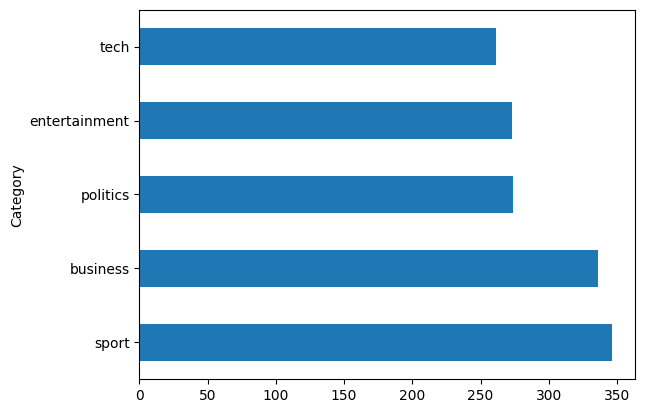

In [7]:
df1['Category'].value_counts().plot(kind='barh')
plt.show()

In [8]:
# Check null values
df1.isnull().sum()

,0
ArticleId,0
Text,0
Category,0


## 2. Text Preprocessing

In [9]:
# Text preprocessing
def preprocess(text):

    """
    Function: split text into words and return the root form of the words
    Args:
      text(str): the article
    Return:
      lem(list of str): a list of the root form of the article words
    """

    # Normalize text
    text = re.sub(r"[^a-zA-Z]", " ", str(text).lower())

    # Tokenize text
    token = word_tokenize(text)

    # Remove stop words
    stop = stopwords.words("english")
    words = [t for t in token if t not in stop]

    # Lemmatization
    lem = [WordNetLemmatizer().lemmatize(w) for w in words]

    return lem

In [10]:
df1["Preprocessed_Text"] = df1['Text'].apply(lambda x: preprocess(x))
df1.head(10)

,ArticleId,Text,Category,Preprocessed_Text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[worldcom, ex, bos, launch, defence, lawyer, d..."
1,154,german business confidence slides german busin...,business,"[german, business, confidence, slide, german, ..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster bett...,tech,"[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,"[enron, boss, payout, eighteen, former, enron,..."
5,1582,howard truanted to play snooker conservative...,politics,"[howard, truanted, play, snooker, conservative..."
6,651,wales silent on grand slam talk rhys williams ...,sport,"[wale, silent, grand, slam, talk, rhys, willia..."
7,1797,french honour for director parker british film...,entertainment,"[french, honour, director, parker, british, fi..."
8,2034,car giant hit by mercedes slump a slump in pro...,business,"[car, giant, hit, mercedes, slump, slump, prof..."
9,1866,fockers fuel festive film chart comedy meet th...,entertainment,"[fockers, fuel, festive, film, chart, comedy, ..."


## 2.1. Text Exploration

In [11]:
# Find the common words in each category
def find_common_words(df, category):

    """
    Function: find the most frequent words in the category and return the them
    Args:
      df(dataframe): the dataframe of articles
      category(str): the category name
    Return:
      the most frequant words in the category
    """

    # Create dataframes for the category
    cat_df = df[df["Category"]==category]

    # Initialize words list for the category
    words = [word for tokens in cat_df["Preprocessed_Text"] for word in tokens]

    # Count words frequency
    words_counter = Counter(words)

    return words_counter.most_common(10)

In [12]:
print("Most common words in each category")
for c in category:
    print(c, " News")
    print(find_common_words(df1, c))
    print()

Most common words in each category
business  News
[('said', 1100), ('year', 618), ('bn', 535), ('u', 523), ('mr', 394), ('company', 393), ('firm', 374), ('market', 346), ('would', 309), ('also', 279)]

tech  News
[('said', 1064), ('people', 647), ('mobile', 437), ('phone', 396), ('game', 396), ('technology', 380), ('service', 371), ('one', 367), ('year', 364), ('mr', 350)]

politics  News
[('said', 1445), ('mr', 1100), ('would', 712), ('labour', 494), ('election', 479), ('government', 471), ('party', 464), ('blair', 396), ('minister', 373), ('people', 372)]

sport  News
[('said', 636), ('game', 487), ('year', 448), ('first', 350), ('win', 337), ('time', 336), ('england', 329), ('player', 311), ('two', 290), ('back', 279)]

entertainment  News
[('film', 721), ('said', 594), ('year', 450), ('best', 430), ('award', 336), ('u', 290), ('also', 277), ('one', 274), ('show', 273), ('star', 259)]



In [13]:
df1['Preprocessed_Text2'] = df1['Preprocessed_Text'].apply(' '.join)
df1.head()

,ArticleId,Text,Category,Preprocessed_Text,Preprocessed_Text2
0,1833,worldcom ex-boss launches defence lawyers defe...,business,"[worldcom, ex, bos, launch, defence, lawyer, d...",worldcom ex bos launch defence lawyer defendin...
1,154,german business confidence slides german busin...,business,"[german, business, confidence, slide, german, ...",german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,"[bbc, poll, indicates, economic, gloom, citize...",bbc poll indicates economic gloom citizen majo...
3,1976,lifestyle governs mobile choice faster bett...,tech,"[lifestyle, governs, mobile, choice, faster, b...",lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,"[enron, boss, payout, eighteen, former, enron,...",enron boss payout eighteen former enron direct...


In [14]:
# Determine data and target
X = df1['Preprocessed_Text2']
y = df1['Category']

In [15]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. Feature Extraction

In [16]:
# Label Encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# 4. Modeling


* Support Vector Machine
* Ada Boost
* Gradient Boosting
* XG Boost
* Decision Tree
* Multinomial Naive Bayes

In [17]:
##############################
# DecisionTreeClassifier
##############################
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', DecisionTreeClassifier(criterion='entropy', max_depth=10, splitter='best', random_state=42))
])
DecisionTreemodel = pipe.fit(x_train, y_train)
prediction = DecisionTreemodel.predict(x_test)
print("Decision Tree Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100, 2)))
DecisionTreemodel_accuracy = round(accuracy_score(y_test, prediction)*100, 2)

Decision Tree Accuracy: 83.89%


In [18]:
##############################
# XGBClassifier
##############################
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', XGBClassifier(learning_rate=0.01, n_estimators=10, max_depth=5, random_state=42, eval_metric='mlogloss', use_label_encoder=False))
])
xgboostmodel = pipe.fit(x_train, y_train)
prediction = xgboostmodel.predict(x_test)
print("XGBoost Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100, 2)))
xgboostmodel_accuracy = round(accuracy_score(y_test, prediction)*100, 2)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:00:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 87.58%


In [19]:
##############################
# SVM
##############################
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', svm.SVC())
])
svmmodel = pipe.fit(x_train, y_train)
prediction = svmmodel.predict(x_test)
print("SVM Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100, 2)))
svmmodel_accuracy = round(accuracy_score(y_test, prediction)*100, 2)

SVM Accuracy: 95.64%


In [20]:
##############################
# AdaBoostClassifier
##############################
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', AdaBoostClassifier(random_state=42))
])
adaboostmodel = pipe.fit(x_train, y_train)
prediction = adaboostmodel.predict(x_test)
print("AdaBoost Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100, 2)))
adaboostmodel_accuracy = round(accuracy_score(y_test, prediction)*100, 2)

AdaBoost Accuracy: 85.91%


In [21]:
##############################
# GradientBoostingClassifier
##############################
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', GradientBoostingClassifier(random_state=42))
])
gbmodel = pipe.fit(x_train, y_train)
prediction = gbmodel.predict(x_test)
print("Gradient Boosting Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100, 2)))
gbmodel_accuracy = round(accuracy_score(y_test, prediction)*100, 2)

Gradient Boosting Accuracy: 94.3%


In [22]:
##############################
# MultinomialNB
##############################
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', MultinomialNB())
])
nbmodel = pipe.fit(x_train, y_train)
prediction = nbmodel.predict(x_test)
print("MultinomialNB Accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100, 2)))
nbmodel_accuracy = round(accuracy_score(y_test, prediction)*100, 2)

MultinomialNB Accuracy: 95.97%


In [24]:
accuracy_scores = {
    "MultinomialNB": nbmodel_accuracy,
    "Decision Tree": DecisionTreemodel_accuracy,
    "XGBoost": xgboostmodel_accuracy,
    "SVM": svmmodel_accuracy,
    "AdaBoost": adaboostmodel_accuracy,
    "Gradient Boosting": gbmodel_accuracy
}


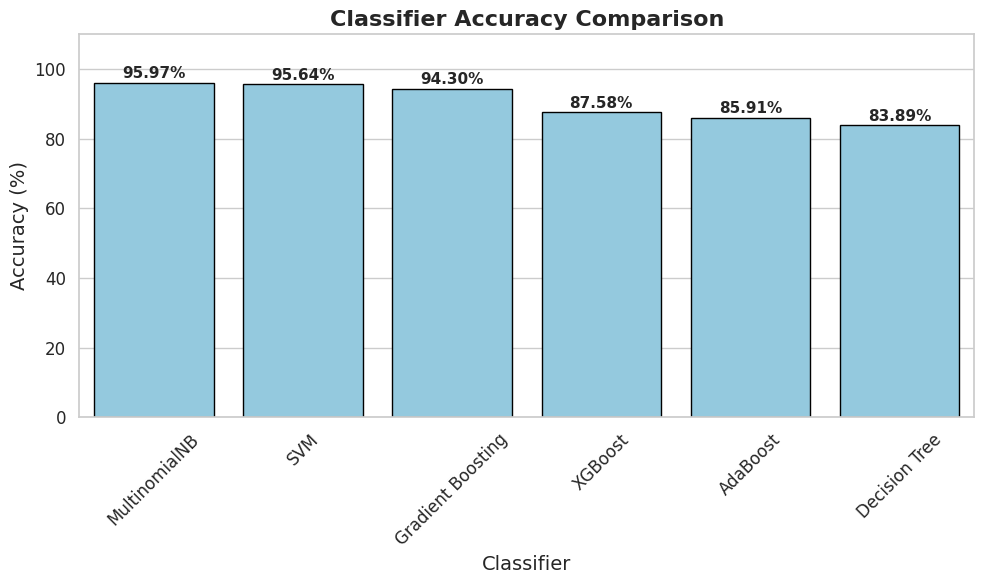

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to DataFrame
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=["Model", "Accuracy"])
accuracy_df.sort_values(by="Accuracy", ascending=False, inplace=True)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x="Model", y="Accuracy", data=accuracy_df,
    color="skyblue", edgecolor="black"
)

# Add accuracy labels on top
for i, row in enumerate(accuracy_df.itertuples()):
    plt.text(i, row.Accuracy + 0.5, f"{row.Accuracy:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

# Format the plot
plt.title("Classifier Accuracy Comparison", fontsize=16, fontweight='bold')
plt.xlabel("Classifier", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.ylim(0, 110)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [28]:
import pickle

# Save the trained MultinomialNB pipeline
with open("model_nb.pkl", "wb") as f:
    pickle.dump(nbmodel, f)

print("MultinomialNB model saved as 'model_nb.pkl'")


MultinomialNB model saved as 'model_nb.pkl'


# 5. Use the Model

In [ ]:
\['business', 'tech', 'politics', 'sport', 'entertainment']